# Havza Algoritması 
- Segmentasyon için, yani görüntüdeki farklı nesneleri ayırmak için kullanılan klasik bir algoritmadır.
- Herhangi bir gri tonlamalı görüntü, yüksek yoğunluğun zirveleri ve tepeleri, düşük yoğunluğun vadileri ifade ettiği bir topografik yüzey olarak görülebilir.
- İzole edilmiş her vadiyi(yerel minimum) farklı renkli suyla(etiketler) doldurmaya başlarsınız
- Su yükseldikçe, yakınlardaki zirvelere(gradyanlara) bağlı olarak, farklı vadilerden gelen su, belli ki farklı renklerle birleşmeye başlayacaktır.Bundan kaçınmak için suyun birleştiği yerlere bariyerler inşa edersiniz.Tüm zirveler su altında kalana kadar su doldurma ve bariyerler inşa etme işlemi devam eder.
- Daha sonra oluşturduğunuz engeller size segmentasyon sonucunu verir.

(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'Original Image'),
 (-0.5, 1023.5, 767.5, -0.5))

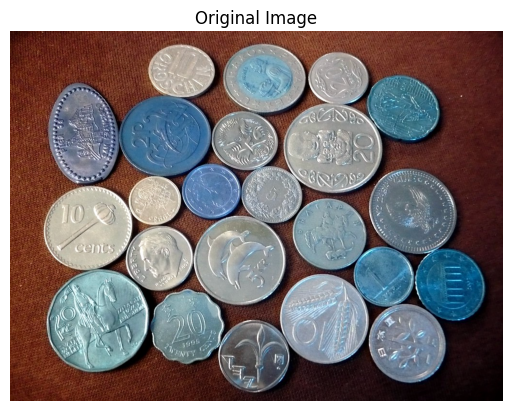

In [1]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np 

# Read image
coin = cv2.imread('coins.jpg')
plt.figure(), plt.imshow(coin), plt.title('Original Image'), plt.axis('off')

(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'Blurred Image'),
 (-0.5, 1023.5, 767.5, -0.5))

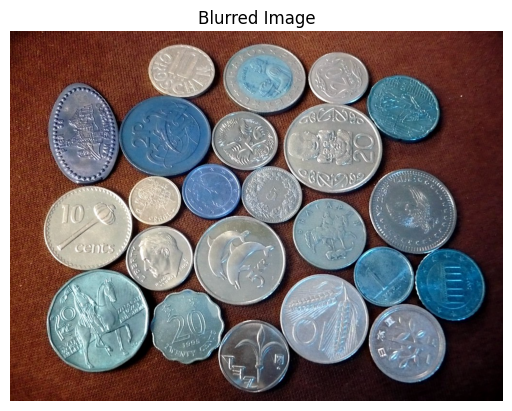

In [2]:
# İstenmeyen detaylardan ve gürültüden kurtulmak low pass filter = blurring
coin_blur = cv2.medianBlur(coin, 13)
plt.figure(), plt.imshow(coin), plt.title('Blurred Image'), plt.axis('off')

(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'Grayscale Image'),
 (-0.5, 1023.5, 767.5, -0.5))

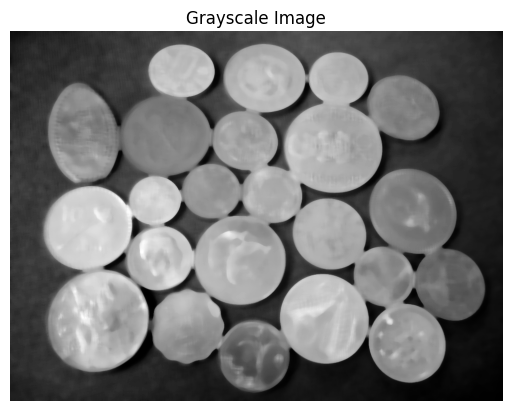

In [3]:
# Grayscale
coin_gray = cv2.cvtColor(coin_blur, cv2.COLOR_BGR2GRAY)
plt.figure(), plt.imshow(coin_gray, cmap='gray'), plt.title('Grayscale Image'), plt.axis('off')

(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'Binary Threshold Image'),
 (-0.5, 1023.5, 767.5, -0.5))

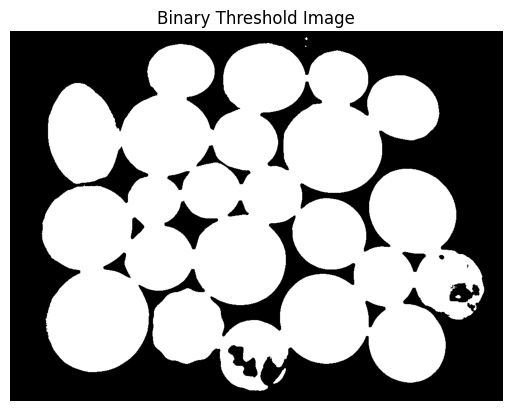

In [16]:
# Binary threshold
ret, coin_thresh = cv2.threshold(coin_gray, 80, 255, cv2.THRESH_BINARY)
plt.figure(), plt.imshow(coin_thresh, cmap='gray'), plt.title('Binary Threshold Image'), plt.axis('off')

(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'Contours Image'),
 (-0.5, 1023.5, 767.5, -0.5))

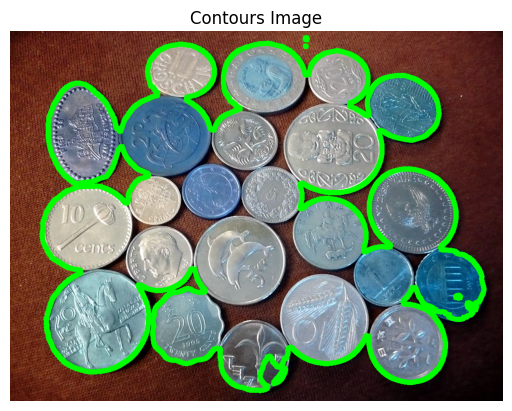

In [17]:
# Kontur
contours, hierrarchy = cv2.findContours(coin_thresh.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
# Kontur çizdirme
for i in range(len(contours)):
    #external contours
    if hierrarchy[0][i][3] == -1:
        cv2.drawContours(coin, contours, i, (0, 255, 0), 10)
plt.figure(), plt.imshow(coin), plt.title('Contours Image'), plt.axis('off')

## Watershed ile iç içe geçmiş nesneleri ayırma 

(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'Opening Image'),
 (-0.5, 1023.5, 767.5, -0.5))

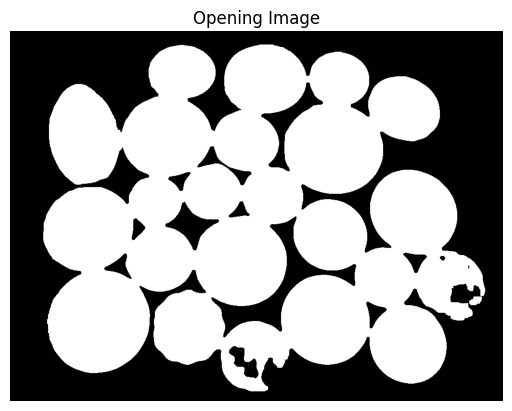

In [18]:
# Açılma işlemi = opening = erosion + dilation
# Nesneler arasındaki köprülerden kurtulmak için
kernel = np.ones((4,4), np.uint8)
opening = cv2.morphologyEx(coin_thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
plt.figure(), plt.imshow(opening, cmap='gray'), plt.title('Opening Image'), plt.axis('off')

(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'Distance Transform Image'),
 (-0.5, 1023.5, 767.5, -0.5))

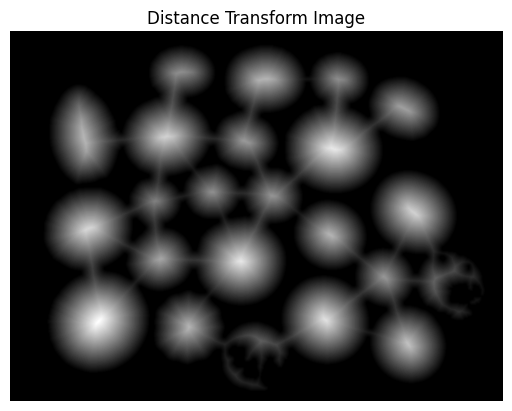

In [19]:
# Nesnler arasındakii distansları hesaplamayalım 
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5) #l2 : euclidean distance
plt.figure(), plt.imshow(dist_transform, cmap='gray'), plt.title('Distance Transform Image'), plt.axis('off')

(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'Sure Foreground Image'),
 (-0.5, 1023.5, 767.5, -0.5))

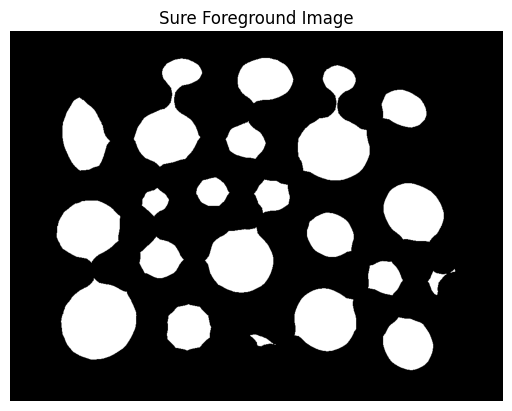

In [20]:
# Resmi Küçültme 
ret, sure_foreground = cv2.threshold(dist_transform, 0.28*np.max(dist_transform), 255, 0)
plt.figure(), plt.imshow(sure_foreground, cmap='gray'), plt.title('Sure Foreground Image'), plt.axis('off')

(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'Adacıkların etrafını belirtme'),
 (-0.5, 1023.5, 767.5, -0.5))

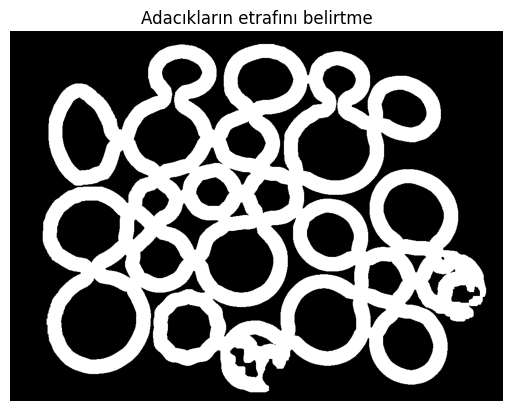

In [21]:
# Arka plan için resmi büyültme
sure_background = cv2.dilate(opening, kernel, iterations=1)
sure_foreground = np.uint8(sure_foreground)
# Arkaplan ve ön plan arasındaki farkı bulalım
unknown = cv2.subtract(sure_background, sure_foreground)
plt.figure(), plt.imshow(unknown, cmap='gray'), plt.title('Adacıkların etrafını belirtme'), plt.axis('off')

(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'Bağlantı'),
 (-0.5, 1023.5, 767.5, -0.5))

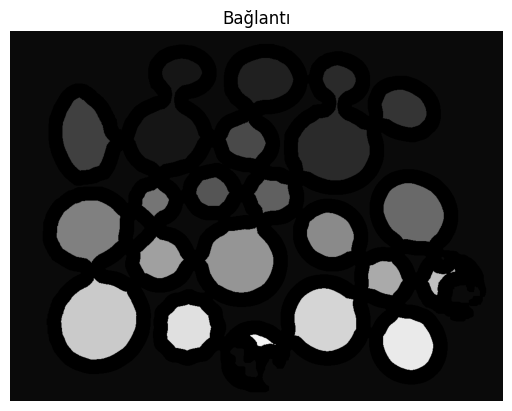

In [22]:
# Bağlantı
ret, marker = cv2.connectedComponents(sure_foreground)
marker = marker + 1
marker[unknown==255] = 0
plt.figure(), plt.imshow(marker, cmap='gray'), plt.title('Bağlantı'), plt.axis('off')

(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'Watershed'),
 (-0.5, 1023.5, 767.5, -0.5))

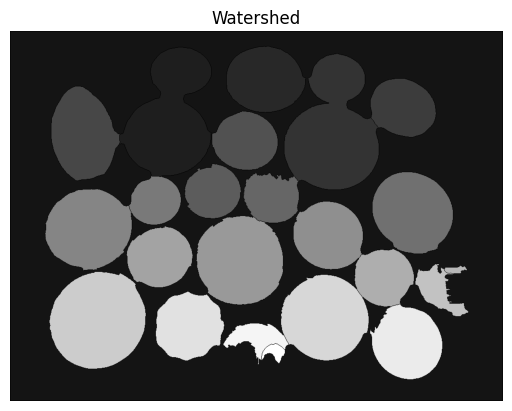

In [23]:
# Watershed algoritması 
marker = cv2.watershed(coin, marker)
plt.figure(), plt.imshow(marker, cmap='gray'), plt.title('Watershed'), plt.axis('off')

(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'Havza Algoritması ile Segmentasyon'),
 (-0.5, 1023.5, 767.5, -0.5))

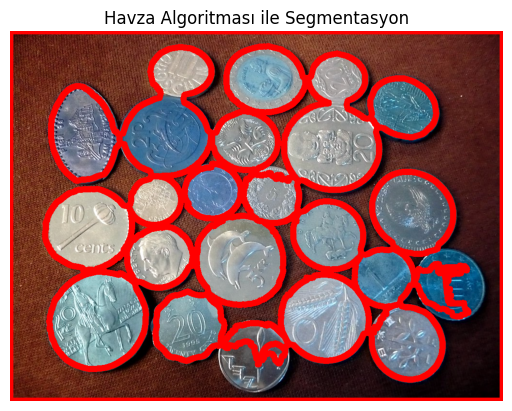

In [25]:
# Kontur çizdirme
contours, hierrarchy = cv2.findContours(marker.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
coin = cv2.imread('coins.jpg')
for i in range(len(contours)):
    #external contours
    if hierrarchy[0][i][3] == -1:
        cv2.drawContours(coin, contours, i, (255, 0, 0), 10)
plt.figure(), plt.imshow(coin), plt.title('Havza Algoritması ile Segmentasyon'), plt.axis('off')